Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls "/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project"

'Starter_code_Assignment_CNN_Skin_Cancer_(1).ipynb'   Test   Train


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


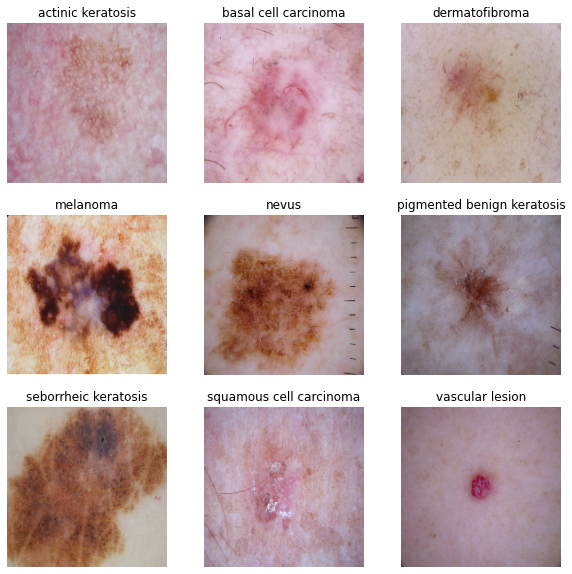

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

fig = plt.figure(figsize=(10, 10))

classes = range(len(class_names))
for images, labels in val_ds.take(5): ### not all image class might be present in single batch. Therefore iterating over multiple batch to find instance from all classes.
    missing = []
    for i in classes:
        ax = fig.add_subplot(3, 3, 1 + i)
        x = np.where(labels[:]==i)[0]
        if len(x) > 0:
            idx = np.where(labels[:]==i)[0][0]
            im = images[idx].numpy().astype("uint8")
            plt.imshow(im)
            plt.title(class_names[labels[idx]])
            plt.axis("off")
        else:
            missing.append(i) ## Adds the missing class
    if len(missing) > 0:
        classes = missing
        continue
    else:
        break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
# model
model = Sequential()
# normalization layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
# first conv layer
model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# second conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# third conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(layers.Dense(9, activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 185s 322ms/step - loss: 1.8038 - accuracy: 0.3337 - val_loss: 1.7004 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5530 - accuracy: 0.4509 - val_loss: 1.4914 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 2s 45ms/step - loss: 1.3757 - accuracy: 0.5190 - val_loss: 1.3786 - val_accuracy: 0.5391
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.2971 - accuracy: 0.5463 - val_loss: 1.3626 - val_accuracy: 0.5459
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.1710 - accuracy: 0.5865 - val_loss: 1.4374 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 44ms/step - loss: 1.0980 - accuracy: 0.6099 - val_loss: 1.3701 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 2s 44ms/step - loss: 1.0183 - accuracy: 0.6429 - val_loss: 1.3641 - val_accuracy: 0.5548
Epoch 8/20
56/56 [===

### Visualizing training results

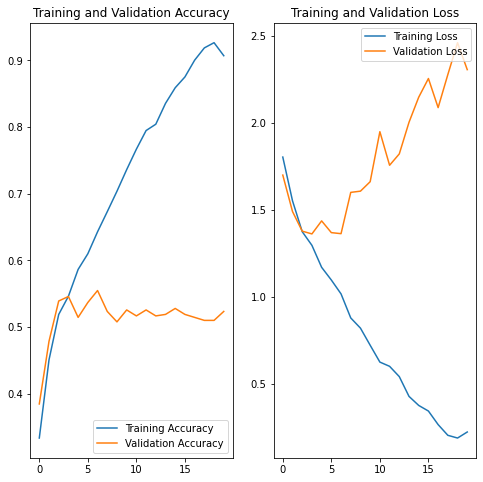

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

## Findings:

*   Training accuracy increases with increse in number of epochs and reaches upto approx 0.9
*   Validation accuracy increases for some ecpochs and then becomes alomost constant at approx 0.5
*   There is a big difference in training accuracy and validation accuracy.
*   This means model is completely overfitting.
*   Training loss decreses with increase in epochs but validation loss increases with increse in epochs.
*   Overfitting happened because of less number of training data and model has learnt from noise or unwanted details around the training data.
*   We can use dropout layer and data augmentation to counter overfitting.
*   Data augmentation will add additional training data by applying transformation on existing data. This will expose the model to more aspects of the data.



In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
   # Random flip of image of horizontal axis
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
   # Random rotation of image
    layers.experimental.preprocessing.RandomRotation(0.2),
   # Random zoom of image
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

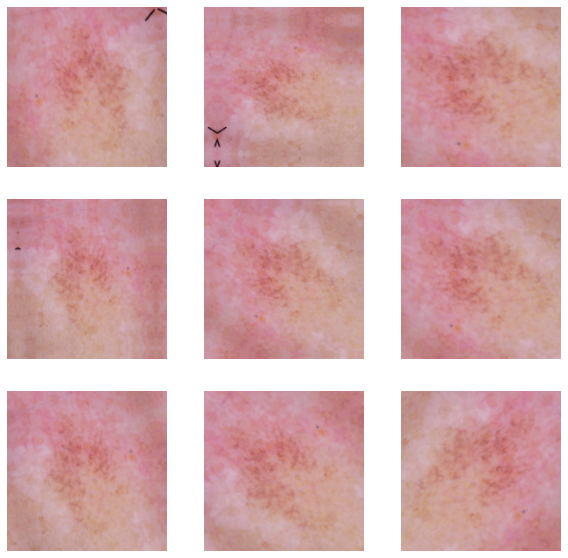

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
# model
model = Sequential()
# data augmentation layer
model.add(data_augmentation)
# normalization layer
model.add(layers.experimental.preprocessing.Rescaling(1./255))
# first conv layer
model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# second conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# third conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# drop out layer
model.add(layers.Dropout(0.2))

# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(layers.Dense(9, activation='softmax'))

# summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                  

### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 5s 55ms/step - loss: 2.1069 - accuracy: 0.2327 - val_loss: 1.9639 - val_accuracy: 0.3378
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.8813 - accuracy: 0.3103 - val_loss: 1.7650 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 1.7247 - accuracy: 0.3694 - val_loss: 1.5934 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 3s 51ms/step - loss: 1.5233 - accuracy: 0.4771 - val_loss: 1.4378 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4473 - accuracy: 0.4927 - val_loss: 1.5050 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 3s 50ms/step - loss: 1.4102 - accuracy: 0.5045 - val_loss: 1.3755 - val_accuracy: 0.5391
Epoch 7/20
56/56 [==============================] - 3s 50ms/step - loss: 1.3962 - accuracy: 0.4933 - val_loss: 1.3409 - val_accuracy: 0.5213
Epoch 8/20
56/56 [======

### Visualizing the results

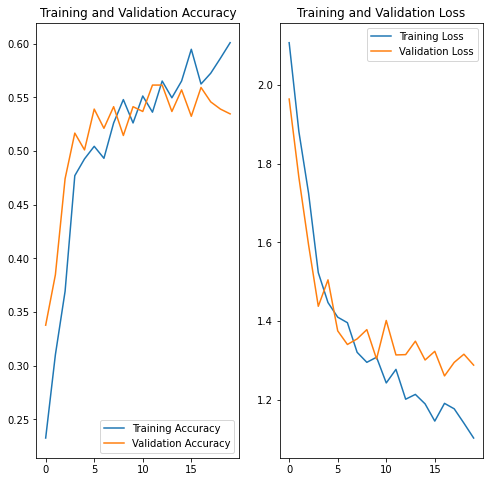

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## Findings:

*   With data augmentation and dropout layer, overfitting problem is solved.
*   Training and validation accuracy is almost equal.
*   But the training accuracy has decreased from approx 0.9 to approx 0.6. This means model is now underfitting.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list


['/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0026709.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0027452.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0030133.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0028190.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0029500.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0027958.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0026702.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0026625.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/ISIC_0027650.jpg',
 

In [24]:
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [25]:
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

## Findings:

*   'seborrheic keratosis' class has least number of samples.
*   'pigmented benign keratosis' and 'melanoma' class dominate the data in terms of proportionate number of samples.



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset=str(data_dir_train) +'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5FA49428D0>: 100%|██████████| 500/500 [00:25<00:00, 19.32 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5FA4C9B710>: 100%|██████████| 500/500 [00:26<00:00, 18.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5FA49B5850>: 100%|██████████| 500/500 [00:27<00:00, 18.29 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F5FA4954DD0>: 100%|██████████| 500/500 [01:46<00:00,  4.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F5FA4C45810>: 100%|██████████| 500/500 [01:39<00:00,  5.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5FA4974C90>: 100%|██████████| 500/500 [00:23<00:00, 21.45 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5FA492E850>: 100%|██████████| 500/500 [00:51<00:00,  9.71 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F60B52A7110>: 100%|██████████| 500/500 [00:24<00:00, 20.49 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F60A0F65890>: 100%|██████████| 500/500 [00:23<00:00, 21.19 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026765.jpg_6416b715-d4b4-4790-a26f-a8780cafde53.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_b6f9b65d-fa51-4fdb-95f0-1af60a9c7160.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028314.jpg_6c3ac3ee-e5c8-4f2c-9f93-967033bafd3f.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_413b303c-7cc0-4b8c-bc49-53651c0c1c95.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_09b95200-a412-4a1d-9d1d-1f00b6d17845.jpg',
 '/content/gdrive/My Drive/Colab Notebooks/Cancer_Detection_Project/Tr

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [31]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [33]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
## your code goes here
# model
model = Sequential()
# data augmentation layer
model.add(data_augmentation)
# normalization layer
model.add(layers.experimental.preprocessing.Rescaling(1./255))
# first conv layer
model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
# max pooling layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# drop out layer
model.add(layers.Dropout(0.2))

# flatten and put a fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # fully connected

# softmax layer
model.add(layers.Dense(9, activation='softmax'))

# summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                  

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [39]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 42s 233ms/step - loss: 1.8118 - accuracy: 0.3056 - val_loss: 1.5765 - val_accuracy: 0.4150
Epoch 2/30
169/169 [==============================] - 40s 229ms/step - loss: 1.5181 - accuracy: 0.4212 - val_loss: 1.4603 - val_accuracy: 0.4892
Epoch 3/30
169/169 [==============================] - 40s 230ms/step - loss: 1.4103 - accuracy: 0.4501 - val_loss: 1.3860 - val_accuracy: 0.4788
Epoch 4/30
169/169 [==============================] - 40s 229ms/step - loss: 1.3490 - accuracy: 0.4831 - val_loss: 1.2901 - val_accuracy: 0.5271
Epoch 5/30
169/169 [==============================] - 40s 228ms/step - loss: 1.2978 - accuracy: 0.4981 - val_loss: 1.2489 - val_accuracy: 0.5226
Epoch 6/30
169/169 [==============================] - 40s 227ms/step - loss: 1.2838 - accuracy: 0.5104 - val_loss: 1.2214 - val_accuracy: 0.5375
Epoch 7/30
169/169 [==============================] - 40s 227ms/step - loss: 1.2171 - accuracy: 0.5308 - val_loss: 1.3405 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

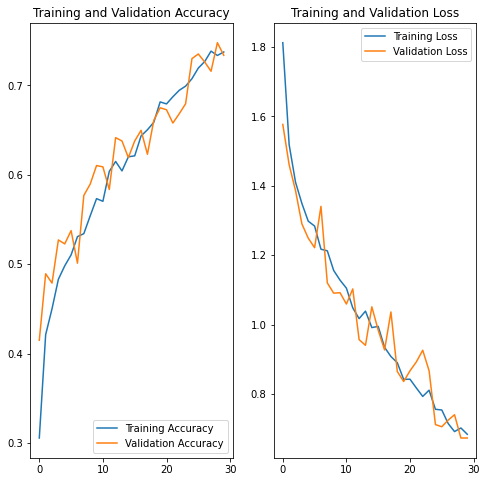

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## Findings:

1.   Final model has no overfitting or underfitting.
2.   Training accuracy is 0.73 and validation accuracy is 0.73 which signifies that model is not overfitting.
3.   Training accuracy and validation accuracy has got significatnt improvement after treating the imbalances for all the classes.
4.   Since training and validation accuracy is good, it is definitely not underfitting. However adding more epochs and more data might increase the  accuracy further.
5.   Training loss and validation loss has also decresed significantly.

